In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

house_df_original = pd.read_csv('./train_house.csv')
house_df = house_df_original.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [3]:
# target은 마지막 col인 SalePrice

print('Shape of data set: ', house_df.shape)
print('\nWhole feature type:\n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull columns and its counts :\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

Shape of data set:  (1460, 81)

Whole feature type:
 object     43
int64      35
float64     3
dtype: int64

Null columns and its counts :
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


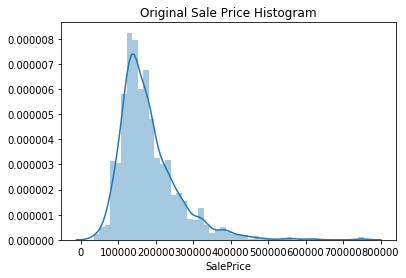

In [4]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

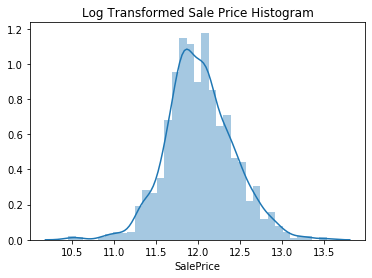

In [5]:
# 왼쪽으로 치우친 target -> log변환으로 정규분포화 시키기
plt.title('Log Transformed Sale Price Histogram')
log_target = np.log1p(house_df['SalePrice'])
sns.distplot(log_target)

In [6]:
# Sale Price log transform
ori_target = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 값 많은 feature, ID 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# drop 하지 않은 숫자형 Null column은 평균으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# 아직 Null값 남은 feature명과 type 추출
null_col_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null feature type: \n', house_df.dtypes[null_col_count.index])

## Null feature type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [7]:
# 남은 문자형 feature -> one hot encoding 실시 (pandas의 get_dummies()이용)
house_df_ohe = pd.get_dummies(house_df)
print('Data shape after executing get_dummies(): ', house_df_ohe.shape)

null_col_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null feature type: \n', house_df_ohe.dtypes[null_col_count.index])

Data shape after executing get_dummies():  (1460, 271)
## Null feature type: 
 Series([], dtype: object)


In [8]:
# 예측 평가로는 RMSLE 이용. 이때 이미 target값을 log변환 했으므로 예측값에 RMSE만 적용하면 됨.
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, 'RMSE in log scaled: ', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)

LinearRegression RMSE in log scaled:  0.129
Ridge RMSE in log scaled:  0.127
Lasso RMSE in log scaled:  0.18


[0.12887072919467282, 0.12745165319172502, 0.1800422510699347]

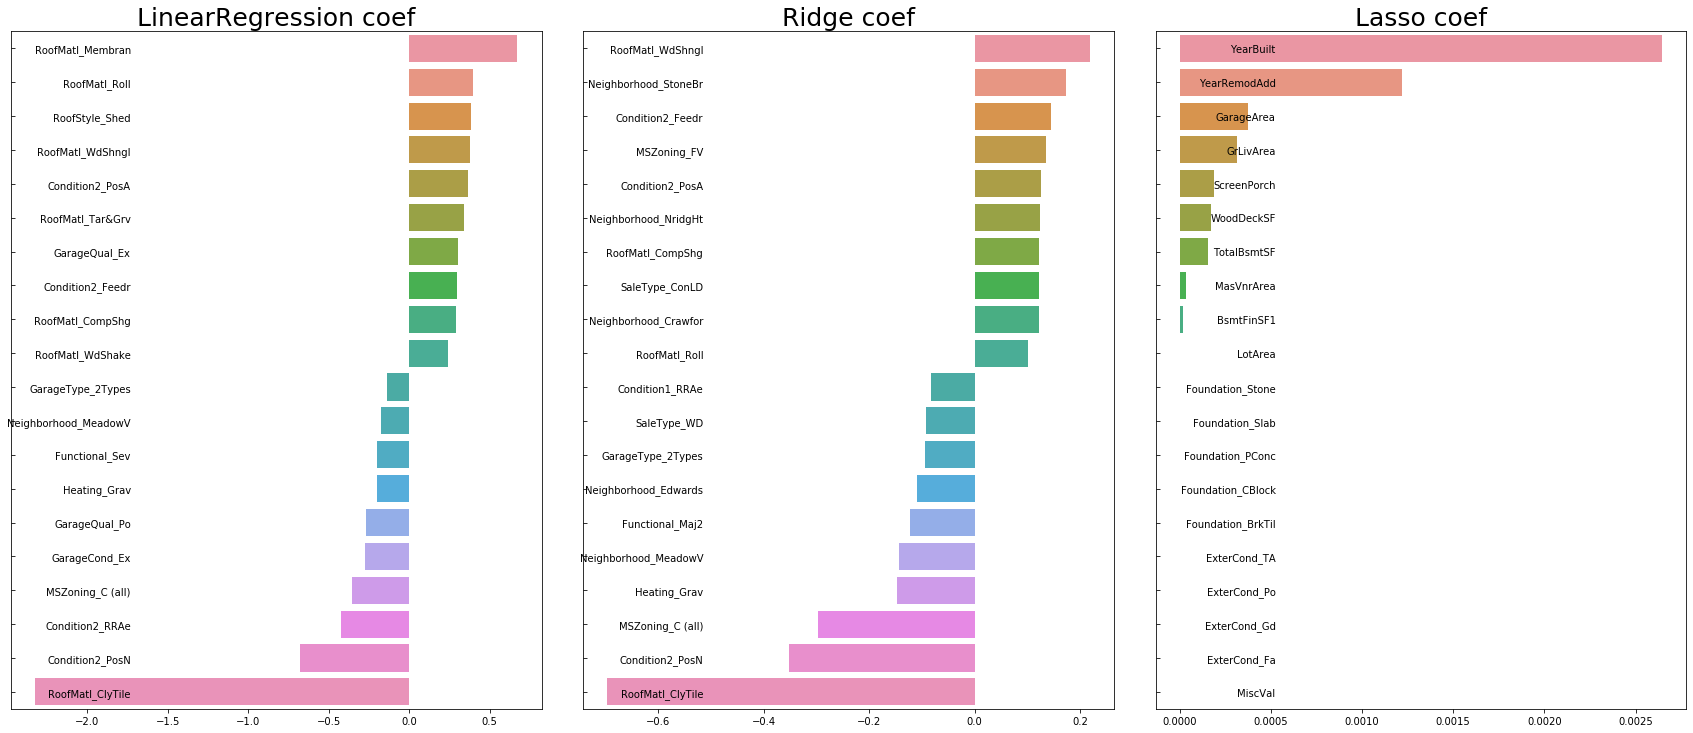

In [10]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)
    coef_h = coef.sort_values(ascending=False).head(n)
    coef_l = coef.sort_values(ascending=False).tail(n)
    return coef_h, coef_l

def visualize_coef(models):
    fig, axs = plt.subplots(figsize=(24,10), ncols=3, nrows=1)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_h, coef_l = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_h, coef_l])
        
        axs[i_num].set_title(model.__class__.__name__ + ' coef', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

visualize_coef(models)

In [11]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV, optimal average RMSE: {1}, optimal alpha: {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1]}

print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV, optimal average RMSE: 0.1418, optimal alpha: {'alpha': 12}
Lasso 5 CV, optimal average RMSE: 0.142, optimal alpha: {'alpha': 0.001}


In [12]:
lr = LinearRegression()
ridge = Ridge(alpha=12)
lasso = Lasso(alpha=0.001)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)

LinearRegression RMSE in log scaled:  0.129
Ridge RMSE in log scaled:  0.128
Lasso RMSE in log scaled:  0.125


[0.12887072919467282, 0.12773677934481129, 0.12489997923870165]

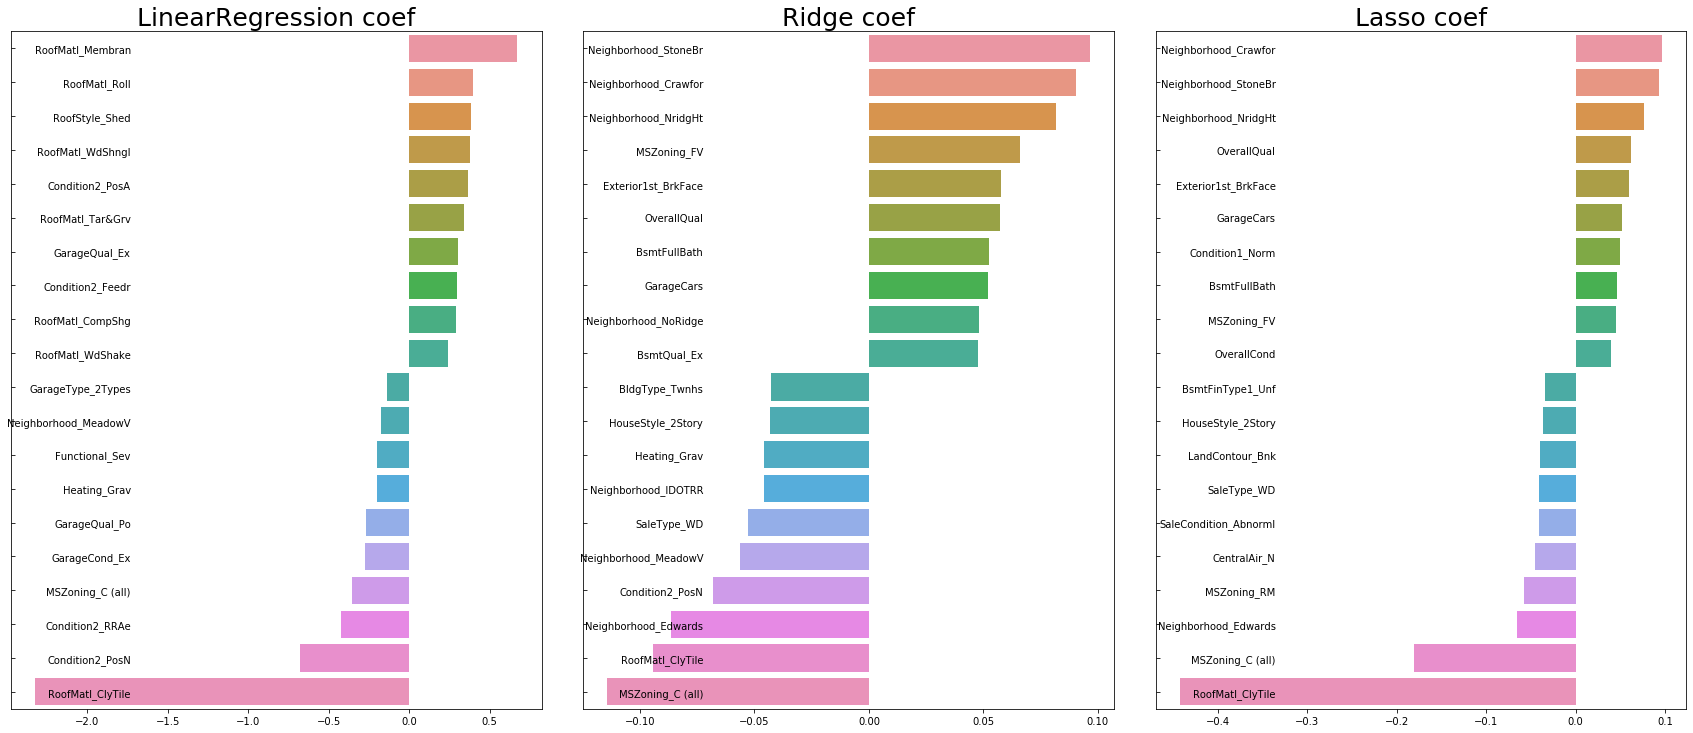

In [13]:
visualize_coef(models)

In [14]:
# lasso도 성능이 좋아지는 것 확인(param인 alpha값 tuning)
# 이제는 dataset 추가 가공
# 1. feature set의 data 분포도
# 2. 이상치 데이터 제거

# 1. feature set data 분포도 확인, 왜곡 정도 보고 로그 변환
from scipy.stats import skew
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[features_index].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [15]:
# 추출된 왜곡 정도 높은 feature는 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1]}

print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV, optimal average RMSE: 0.1275, optimal alpha: {'alpha': 10}
Lasso 5 CV, optimal average RMSE: 0.1252, optimal alpha: {'alpha': 0.001}


In [16]:
lr = LinearRegression()
ridge = Ridge(alpha=1)
lasso = Lasso(alpha=0.001)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)

LinearRegression RMSE in log scaled:  0.186
Ridge RMSE in log scaled:  0.165
Lasso RMSE in log scaled:  0.157


[0.18587684993136075, 0.16484864249538678, 0.15743820008495746]

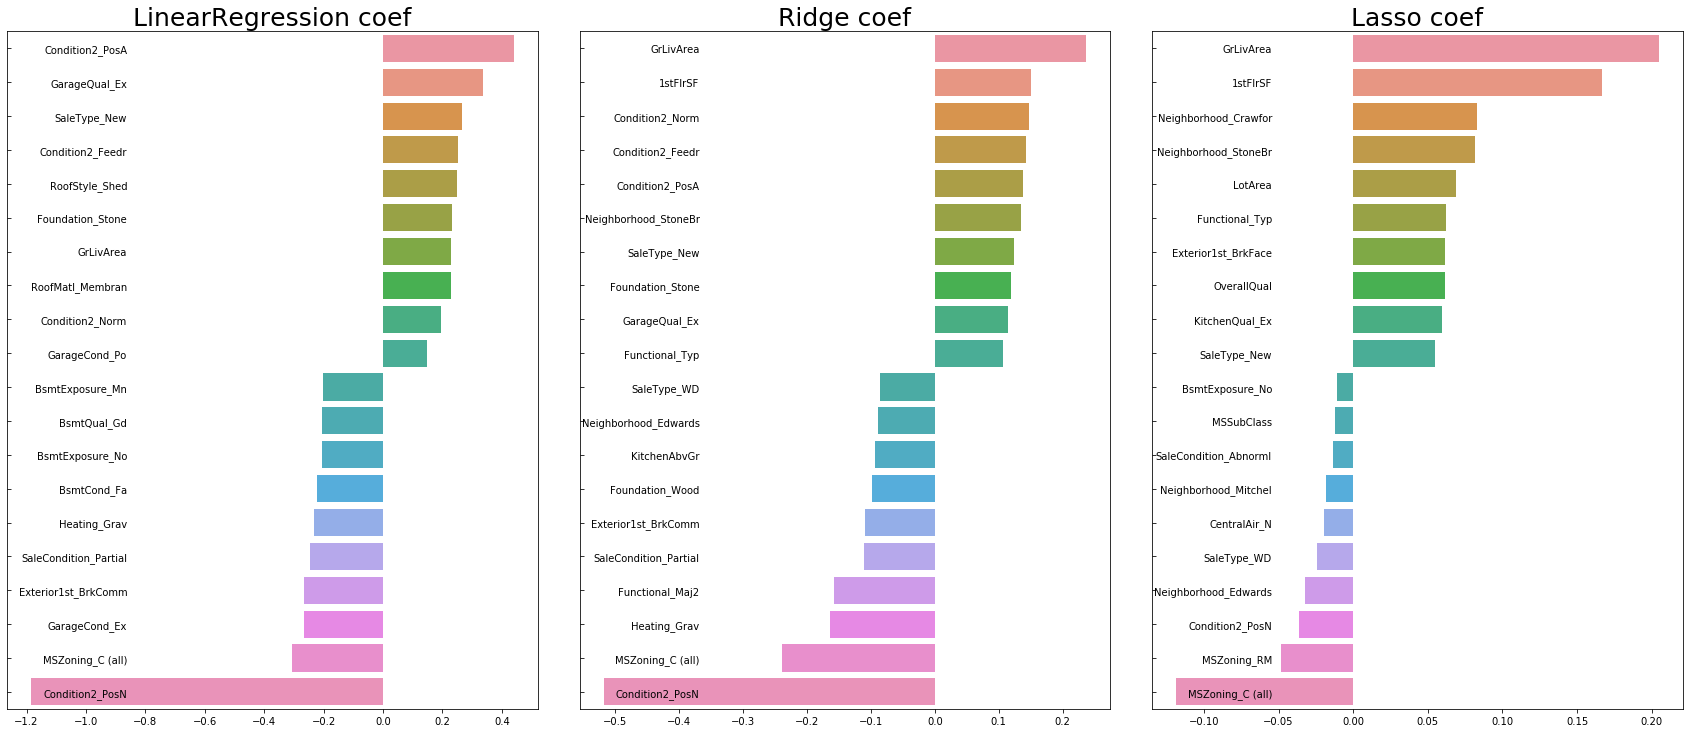

In [17]:
visualize_coef(models)

<function matplotlib.pyplot.show(*args, **kw)>

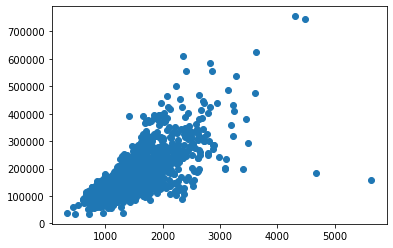

In [18]:
# 2. 이상치 데이터 제거
plt.scatter(x=house_df_original['GrLivArea'], y=house_df_original['SalePrice'])
plt.show

In [19]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)

outlier_index = house_df_ohe[cond1 & cond2].index
house_df_ohe.drop(outlier_index, axis=0, inplace=True)

In [20]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 9, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1]}

print_best_params(ridge, ridge_params)
print_best_params(lasso, lasso_params)

Ridge 5 CV, optimal average RMSE: 0.1125, optimal alpha: {'alpha': 8}
Lasso 5 CV, optimal average RMSE: 0.1122, optimal alpha: {'alpha': 0.001}


In [21]:
lr = LinearRegression()
ridge = Ridge(alpha=8)
lasso = Lasso(alpha=0.001)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmses(models)

LinearRegression RMSE in log scaled:  0.108
Ridge RMSE in log scaled:  0.103
Lasso RMSE in log scaled:  0.105


[0.10769798900668633, 0.10334740221865572, 0.1052849663905527]

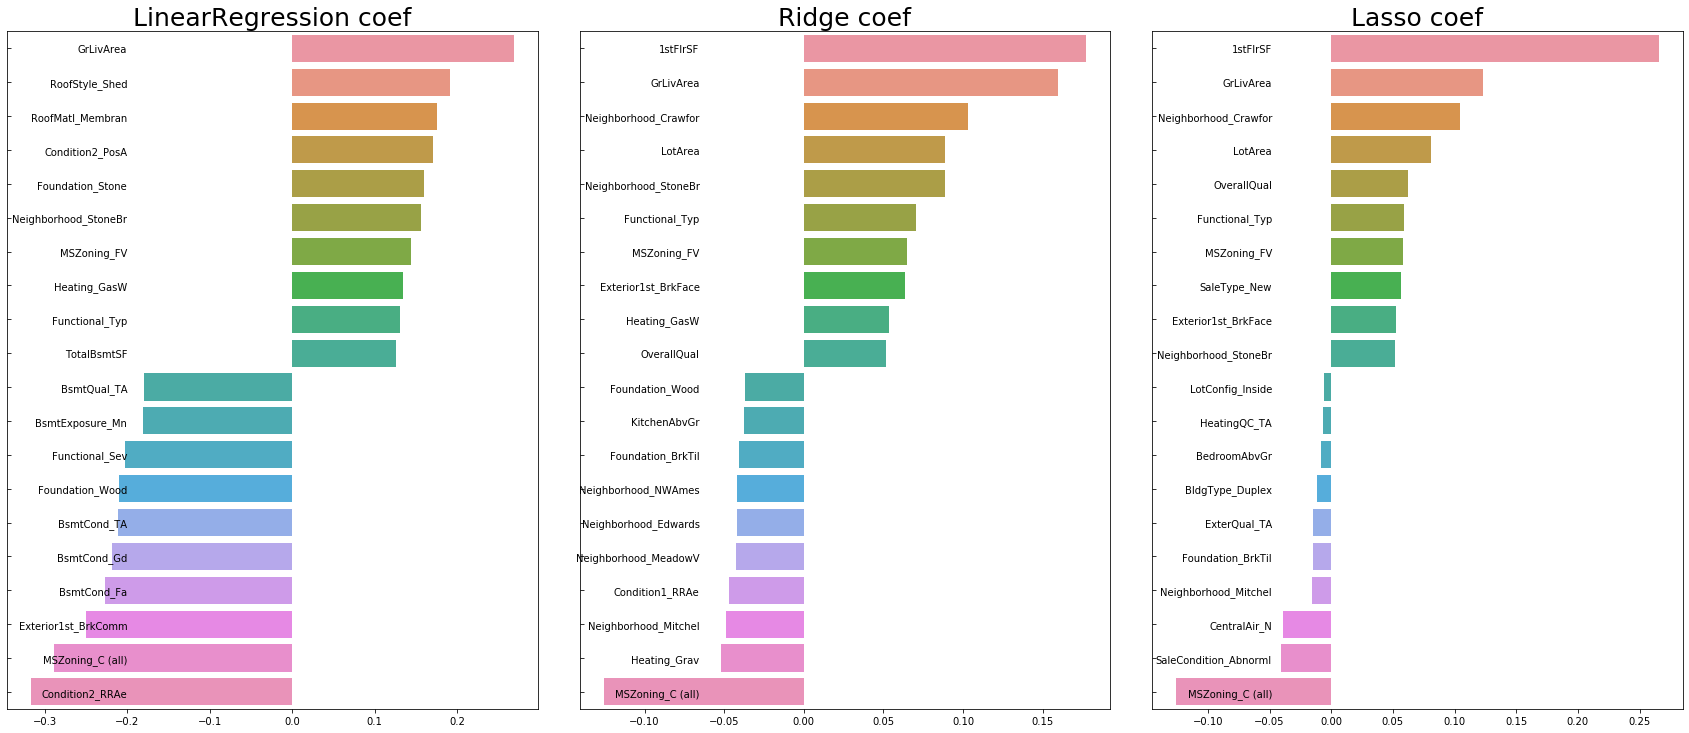

In [22]:
# 2개의 이상치 데이터만 제거했는데 예측 수치 향상
visualize_coef(models)

In [23]:
# 회귀 트리 모델 학습/예측/평가
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree = 0.5, subsample=0.8)
print_best_params(xgb, xgb_params)

[15:00:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV, optimal average RMSE: 0.115, optimal alpha: {'n_estimators': 1000}


[15:04:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


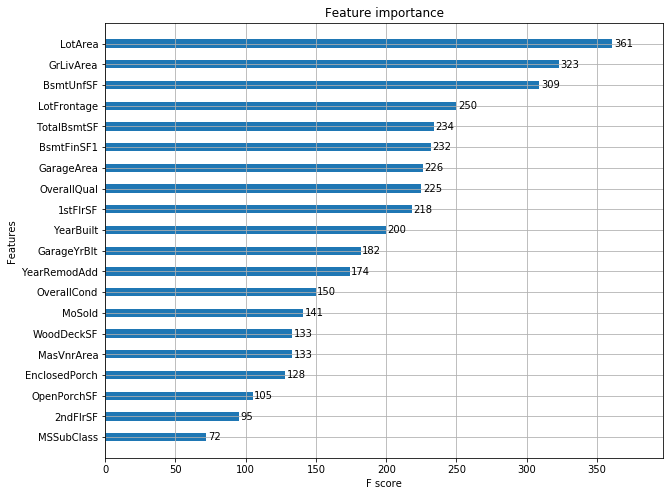

In [27]:
xgb.fit(X_train, y_train)
from xgboost import plot_importance
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_importance(xgb, ax=ax, max_num_features=20, height=0.4)

In [29]:
# 회귀 모델 예측 결과 혼합
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} Model RMSE : {1}'.format(key, rmse))
        
ridge_pred = ridge.predict(X_test)
lasso_pred = lasso.predict(X_test)

pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'Combined': pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}

get_rmse_pred(preds)

Combined Model RMSE : 0.1034105855436908
Ridge Model RMSE : 0.10334740221865572
Lasso Model RMSE : 0.1052849663905527


In [34]:
# 스태킹 앙상블 모델을 통한 회귀 예측시 결과 더 좋아짐
from sklearn.model_selection import KFold
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' starts ----')
    
    for folder_cnt, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t fold set ', folder_cnt, ' starts --')
        X = X_train_n[train_index]
        y = y_train_n[train_index]
        v = X_train_n[valid_index]
        model.fit(X, y)
        train_fold_pred[valid_index,:] = model.predict(v).reshape(-1,1)
        test_pred[:, folder_cnt] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1) # 결국 최종형 형태가 column vector 꼴이므로 axis = 1
    
    return train_fold_pred, test_pred_mean

X_train_n = X_train.values
y_train_n = y_train.values
X_test_n = X_test.values

from lightgbm import LGBMRegressor

xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree = 0.5, subsample=0.8)
lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree = 0.4, subsample=0.6, reg_lambda=10)

r_train, r_test = get_stacking_base_datasets(ridge, X_train_n, y_train_n, X_test_n)
l_train, l_test = get_stacking_base_datasets(lasso, X_train_n, y_train_n, X_test_n)
x_train, x_test = get_stacking_base_datasets(xgb, X_train_n, y_train_n, X_test_n)
lg_train, lg_test = get_stacking_base_datasets(lgbm, X_train_n, y_train_n, X_test_n)
    
stack_final_X_train = np.concatenate((r_train, l_train, x_train, lg_train), axis=1)
stack_final_X_test = np.concatenate((r_test, l_test, x_test, lg_test), axis=1)

meta_model = Lasso(alpha=0.0005)

meta_model.fit(stack_final_X_train, y_train)
final = meta_model.predict(stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('Final RMSE: ', rmse)
    

Ridge  starts ----
	 fold set  0  starts --
	 fold set  1  starts --
	 fold set  2  starts --
	 fold set  3  starts --
	 fold set  4  starts --
Lasso  starts ----
	 fold set  0  starts --
	 fold set  1  starts --
	 fold set  2  starts --
	 fold set  3  starts --
	 fold set  4  starts --
XGBRegressor  starts ----
	 fold set  0  starts --
[15:35:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set  1  starts --
[15:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set  2  starts --
[15:35:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set  3  starts --
[15:35:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 fold set  4  starts --
[15:35:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of